In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy
Path='/home/mgander/Atlantic/data/Viability/'

In [2]:
def fct(x, a, b, c, d):
    return a + (b-a) / (1+10**(-c*(x-d)))

In [3]:
M = pd.read_pickle(f'{Path}/M_all_all.pkl')

In [4]:
M = M[M.Source!='PRISM1'].copy()

In [5]:
sources = sorted(set(M['Source']))
sources

['CTD2', 'CTPR', 'DTP', 'GDSC1', 'GDSC2', 'MR_NCI60', 'PRISM2']

In [6]:
def add_ccl_and_drugs_annot(df):
    df['Cello']=[a.split('_')[0] for a in df.index]
    df['PubChem_CID']=[a.split('_')[1] for a in df.index]
    df['pEC50'] = - df['-pec50']
    del df['-pec50']
    return(df)
def fct(x, a, b, c, d):
    return a + (b-a) / (1+10**(-c*(x-d)))

In [7]:
F={}
F['CTD2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_ctd2.pkl'))
F['CTPR'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_ctrp.pkl'))
F['DTP'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_dtp.pkl'))
F['GDSC1'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_gdsc1.pkl'))
F['GDSC2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_gdsc2.pkl'))
F['MR_NCI60'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_inhouse.pkl'))
F['PRISM2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_prism.pkl'))

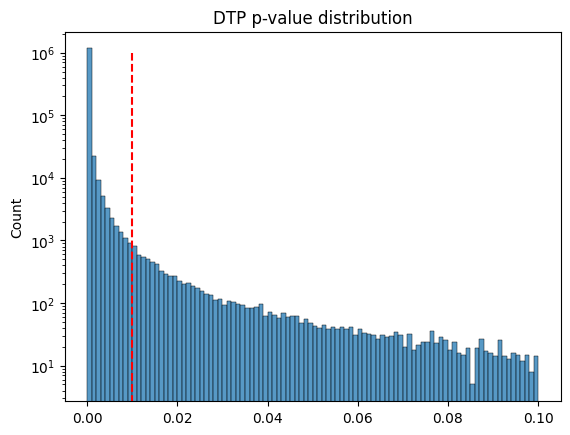

In [8]:
sns.histplot(list(F['DTP']['p_value']), bins=np.linspace(0,0.1,101))
plt.yscale('log')
plt.title('DTP p-value distribution')
plt.plot([0.01, 0.01], [0,10**6], c='r', linestyle='--')

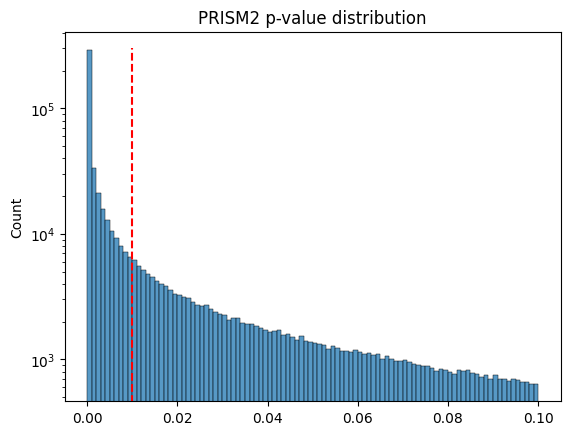

In [9]:
sns.histplot(list(F['PRISM2']['p_value']), bins=np.linspace(0,0.1,101))
plt.yscale('log')
plt.title('PRISM2 p-value distribution')
plt.plot([0.01, 0.01], [0,3*10**5], c='r', linestyle='--')

In [12]:
ks = list(F.keys())
Fr = {}
for k in ks:
    Fr[k] = [(F[k]['p_value']>0.01).mean()*100]

In [13]:
dffr = pd.DataFrame(Fr)
dffr.columns = ['CTRP_v2', 'CTRP_v1', 'DTP', 'GDSC_v1', 'GDSC_v2', 'NCI60', 'PRISM2']
dffr = dffr[['NCI60', 'CTRP_v1', 'CTRP_v2', 'DTP', 'GDSC_v1', 'GDSC_v2', 'PRISM2']].T
dffr['Source'] = dffr.index

Text(0, 0.5, 'Percentage of Removed Curves')

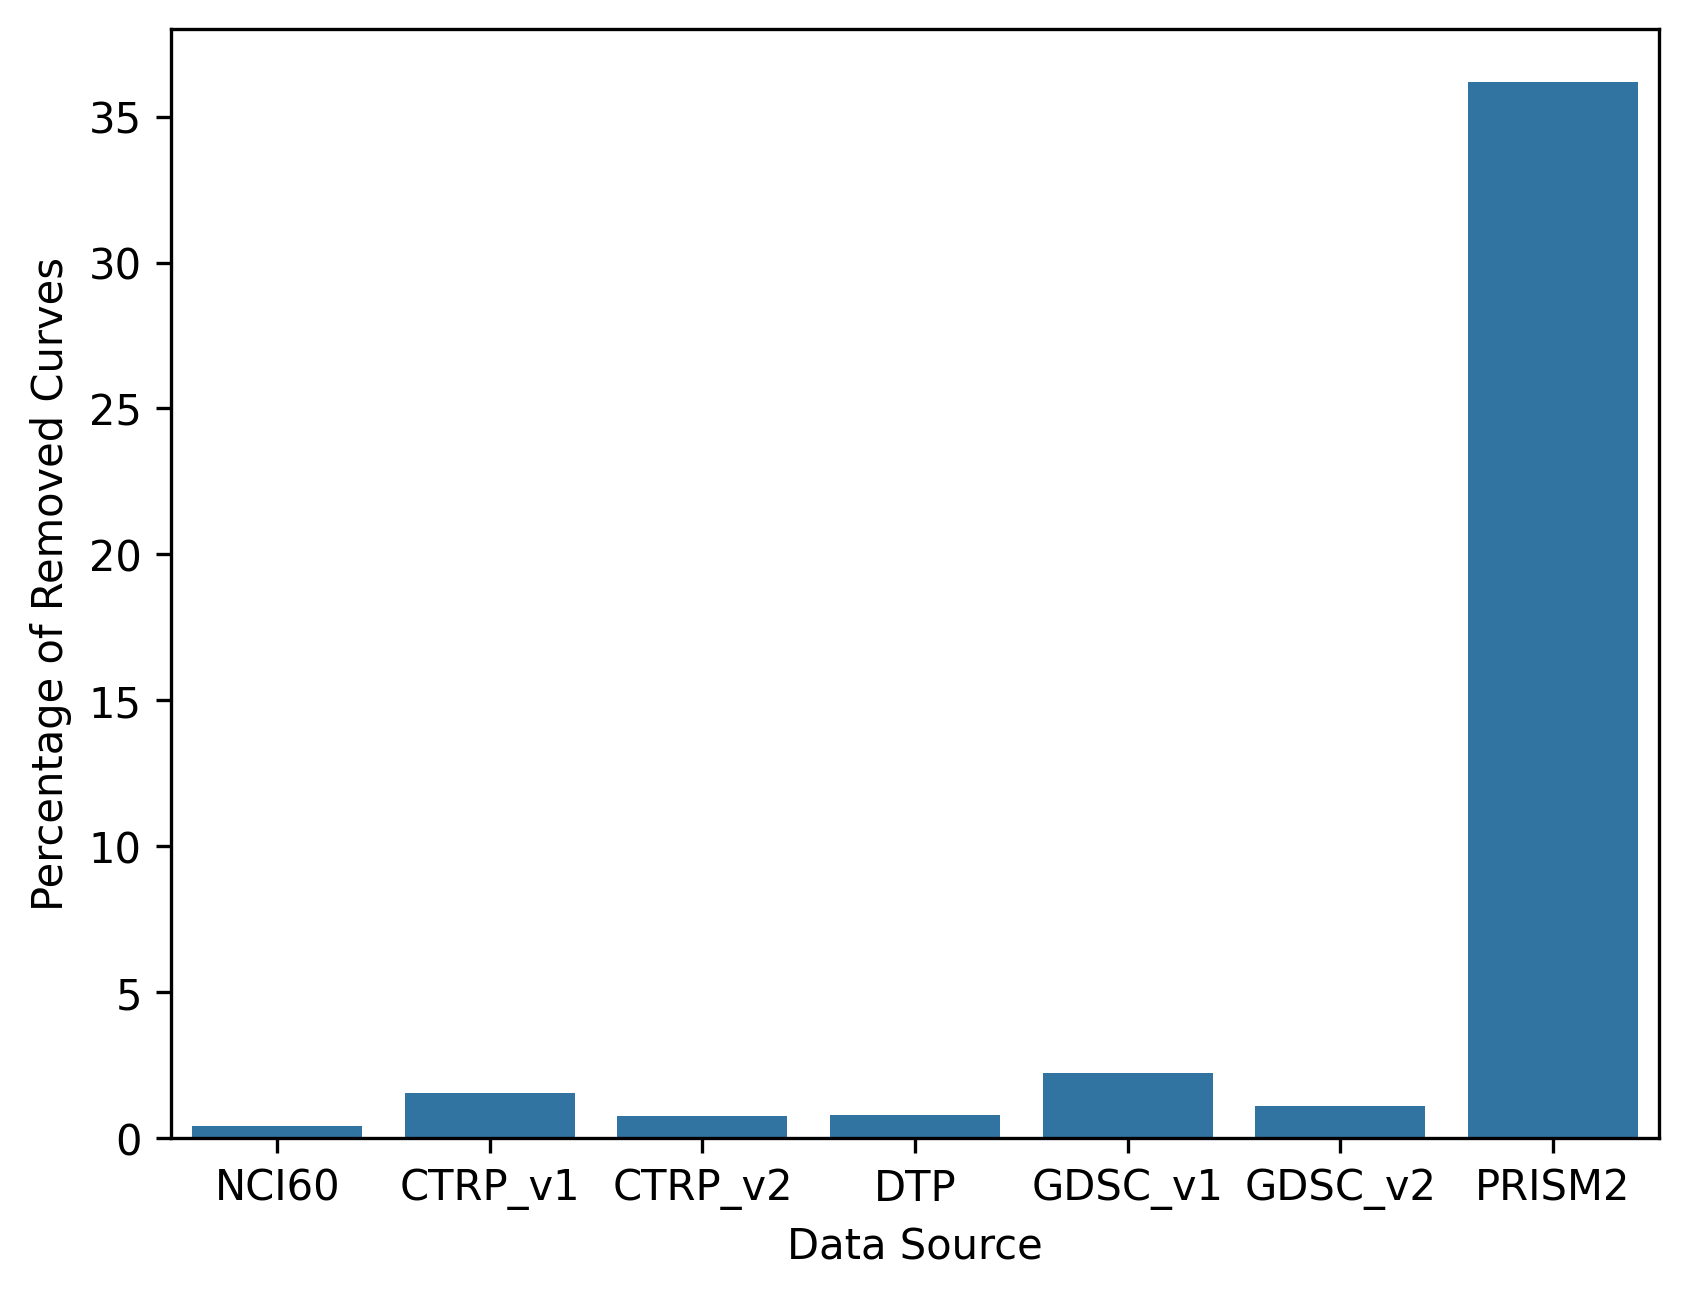

In [14]:
plt.rcParams['figure.dpi'] = 300
sns.barplot(dffr, y=0, x='Source')
plt.xlabel('Data Source')
plt.ylabel('Percentage of Removed Curves')

In [15]:
dffr

0   Source
NCI60     0.415266    NCI60
CTRP_v1   1.552056  CTRP_v1
CTRP_v2   0.752905  CTRP_v2
DTP       0.805722      DTP
GDSC_v1   2.241790  GDSC_v1
GDSC_v2   1.104485  GDSC_v2
PRISM2   36.178505   PRISM2

In [16]:
ks = list(F.keys())
# remove all nan's and all curves with p_value>0.01
k=ks[0]

In [17]:
frames = []
F_new = {}
for k in ks:
    dfs = F[k]
    dfs['Source'] = k
    frames.append(dfs[(~np.isfinite(dfs['pEC50']))|(dfs['p_value']>0.01)][['PubChem_CID', 'Cello', 'Source']])
    F_new[k] = dfs[(np.isfinite(dfs['pEC50']))&(dfs['p_value']<0.01)]
Df_remove = pd.concat(frames, ignore_index=True)

In [18]:
Df_remove['key'] = Df_remove['PubChem_CID']+'_'+Df_remove['Cello']+'_'+Df_remove['Source']

In [19]:
M['key'] =  M['PubChem_CID'].astype('str')+'_'+M['Cello'].astype('str')+'_'+M['Source'].astype('str')

In [20]:
M['key'] = M['key'].astype('category')
M

CCL          Drug      Dose  Duration  Viability  Source  \
0         CAS1         CIL55   0.00030      72.0   0.948448    CTD2   
1         CAS1         CIL55   0.00030      72.0   0.912565    CTD2   
2         CAS1         CIL55   0.00061      72.0   0.880625    CTD2   
3         CAS1         CIL55   0.00061      72.0   0.789330    CTD2   
4         CAS1         CIL55   0.00120      72.0   0.973525    CTD2   
...        ...           ...       ...       ...        ...     ...   
51426148    TT    bortezomib  20.00070     120.0   0.301302  PRISM2   
51426149    TT      oltipraz   0.00977     120.0   0.789436  PRISM2   
51426150    TT        AZ-628  10.00000     120.0   0.845885  PRISM2   
51426151    TT  alvespimycin   0.15600     120.0   1.563180  PRISM2   
51426152    TT    paclitaxel   0.03910     120.0   2.186966  PRISM2   

         CCL_reduced Cello PubChem_CID  Dr_repr_name                 key  
0               CAS1  CAS1     6623618         CIL55   6623618_CAS1_CTD2  
1               CAS1  CAS1     6623618         CIL55   6623618_CAS1_CTD2  
2               CAS1  CAS1     6623618         CIL55   6623618_CAS1_CTD2  
3               CAS1  CAS1     6623618         CIL55   6623618_CAS1_CTD2  
4               CAS1  CAS1     6623618         CIL55   6623618_CAS1_CTD2  
...              ...   ...         ...           ...                 ...  
51426148          TT    TT      387447    bortezomib    387447_TT_PRISM2  
51426149          TT    TT       47318      oltipraz     47318_TT_PRISM2  
51426150          TT    TT    11676786         AZ628  11676786_TT_PRISM2  
51426151          TT    TT     5288674  alvespimycin   5288674_TT_PRISM2  
51426152          TT    TT       36314    paclitaxel     36314_TT_PRISM2  

[43473761 rows x 11 columns]

In [21]:
M = M[~M['key'].isin(list(Df_remove['key']))].copy()
M

CCL           Drug      Dose  Duration  Viability  Source  \
0         CAS1          CIL55   0.00030      72.0   0.948448    CTD2   
1         CAS1          CIL55   0.00030      72.0   0.912565    CTD2   
2         CAS1          CIL55   0.00061      72.0   0.880625    CTD2   
3         CAS1          CIL55   0.00061      72.0   0.789330    CTD2   
4         CAS1          CIL55   0.00120      72.0   0.973525    CTD2   
...        ...            ...       ...       ...        ...     ...   
51426130    TT         FK-866   0.62500     120.0   0.301171  PRISM2   
51426138    TT       imatinib   0.00061     120.0   0.618413  PRISM2   
51426140    TT  gambogic-acid   0.62500     120.0   0.288984  PRISM2   
51426143    TT   tamibarotene   0.15625     120.0   1.004438  PRISM2   
51426148    TT     bortezomib  20.00070     120.0   0.301302  PRISM2   

         CCL_reduced Cello PubChem_CID   Dr_repr_name                 key  
0               CAS1  CAS1     6623618          CIL55   6623618_CAS1_CTD2  
1               CAS1  CAS1     6623618          CIL55   6623618_CAS1_CTD2  
2               CAS1  CAS1     6623618          CIL55   6623618_CAS1_CTD2  
3               CAS1  CAS1     6623618          CIL55   6623618_CAS1_CTD2  
4               CAS1  CAS1     6623618          CIL55   6623618_CAS1_CTD2  
...              ...   ...         ...            ...                 ...  
51426130          TT    TT     6914657      daporinad   6914657_TT_PRISM2  
51426138          TT    TT        5291       imatinib      5291_TT_PRISM2  
51426140          TT    TT    99639195  gambogic-acid  99639195_TT_PRISM2  
51426143          TT    TT      108143   tamibarotene    108143_TT_PRISM2  
51426148          TT    TT      387447     bortezomib    387447_TT_PRISM2  

[38147269 rows x 11 columns]

In [97]:
# Make sure all are consistent

In [22]:
Fc = pd.concat(F)

In [25]:
Fc = Fc.reset_index()

In [26]:
Fc['key'] = Fc['PubChem_CID'].astype('str')+'_'+Fc['Cello'].astype('str')+'_'+Fc['Source'].astype('str')

In [28]:
m_keys = sorted(set(M['key']))
f_keys = sorted(set(Fc['key']))

In [29]:
len(m_keys)

2597453

In [30]:
len(f_keys)

2907005

In [31]:
len(set(f_keys)&set(m_keys))

2552371

In [32]:
key_intersect = sorted(set(f_keys)&set(m_keys))

In [33]:
M = M[M['key'].isin(key_intersect)].copy()

In [35]:
for k in ks:
    dfs = F[k].copy()
    dfs['key'] = dfs['PubChem_CID'].astype('str')+'_'+dfs['Cello'].astype('str')+'_'+dfs['Source'].astype('str')
    dfs = dfs[dfs['key'].isin(key_intersect)].copy()
    F[k]=dfs.copy()

In [36]:
M.to_pickle(f'{Path}/M_cleaned.pkl')

In [ ]:
# And without PRISM2

In [37]:
import pickle
with open('F_cleaned.pkl', 'wb') as file:
    pickle.dump(F_new, file)

In [41]:
M = M[M['Source']!='PRISM2'].copy()
M['Source'] = [a for a in M['Source']]
M['Source'] = M['Source'].astype('category')

In [42]:
M.to_pickle(f'{Path}/M_cleaned2.pkl')